In [1]:
import requests
import pandas as pd
import os

#create new repo for crypto-project and place the Jupyter Notebook in it
#os.mkdir('/home/ubuntu/crypto-project')
#!mv /home/ubuntu/random-cut-forest.ipynb /home/ubuntu/crypto-project

#url for obtaining minute-by-minute Bitcoin OHTV data from the Bitfinex exchange
url = 'https://min-api.cryptocompare.com/data/histominute?fsym=BTC&tsym=USD&e=Bitfinex'
f = requests.get(url)
ipdata = f.json()
btc = pd.DataFrame(ipdata['Data'])
btc.head()


,close,high,low,open,time,volumefrom,volumeto
0,6262.1,6262.1,6262.0,6262.1,1536539580,0.6874,4304.29
1,6262.1,6262.1,6262.1,6262.1,1536539640,2.7900,17444.13
2,6262.1,6262.1,6262.1,6262.1,1536539700,2.2800,14295.54
3,6265.1,6265.1,6262.1,6262.1,1536539760,3.4500,21590.34
4,6258.9,6265.1,6258.0,6265.1,1536539820,7.9700,49894.88


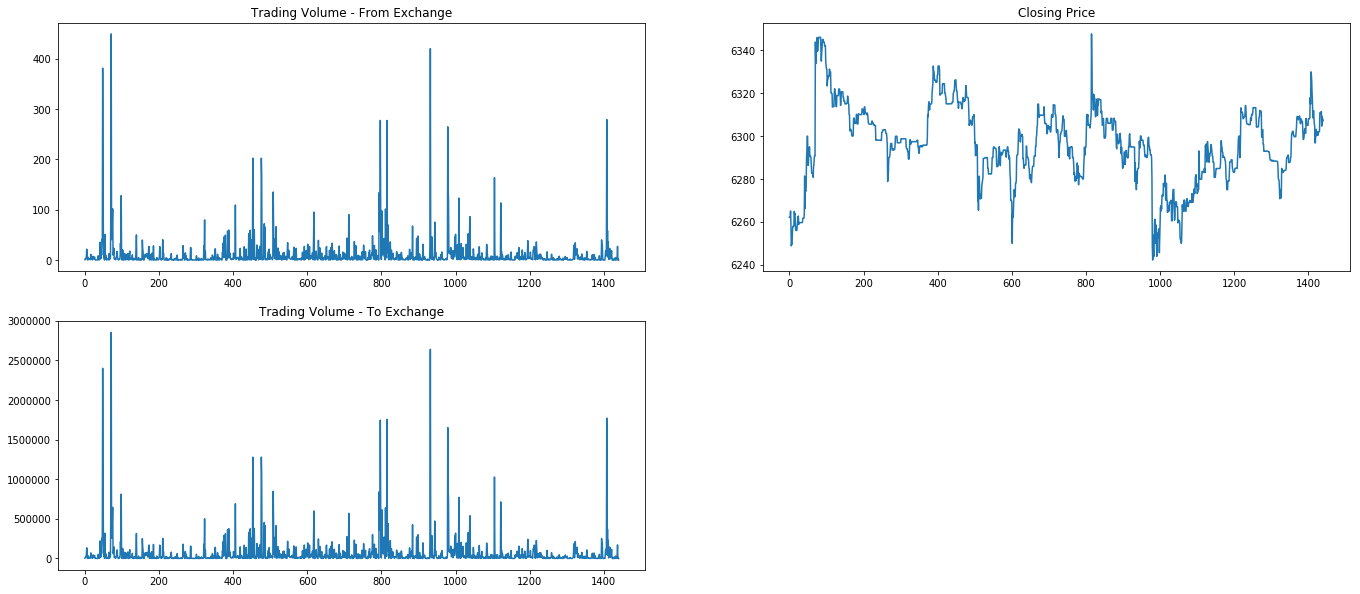

In [3]:
import matplotlib.pyplot as plt

plt.subplot(221)
plt.plot(btc['volumefrom'])
plt.title('Trading Volume - From Exchange')

plt.subplot(222)
plt.plot(btc['close'])
plt.title('Closing Price')

plt.subplot(223)
plt.plot(btc['volumeto'])
plt.title('Trading Volume - To Exchange')

plt.subplots_adjust(left=0.01, right = 3, wspace=0.2, bottom = 0.1, top=2)

plt.show()


In [8]:
#Random Cut Forest reference from AWS (contains good tips re: model training inputs)
#https://aws.amazon.com/blogs/machine-learning/use-the-built-in-amazon-sagemaker-random-cut-forest-algorithm-for-anomaly-detection/


# creates a .pbr file and stores in the s3 bucket
def convert_and_upload_training_data(
    ndarray, bucket, prefix, filename='btcdata9-9.pbr'):
    import boto3
    import os
    from sagemaker.amazon.common import numpy_to_record_serializer

    # convert Numpy array to Protobuf RecordIO format
    serializer = numpy_to_record_serializer()
    buffer = serializer(ndarray)

    # upload to S3
    s3_object = os.path.join(prefix, 'train', filename)
    boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_fileobj(buffer)
    s3_path = 's3://{}/{}'.format(bucket, s3_object)
    return s3_path

bucket = 'ads-bucket-senichol' # <-- use your own bucket here
prefix = 'sagemaker/randomcutforest' # <-- label your own file directory
s3_train_data = convert_and_upload_training_data(
    btc.as_matrix().reshape(-1,1), # <-- you can subset the data: e.g. btc.volumeto.as_matris().reshape(-1,1),
    bucket,
    prefix)

In [63]:
import boto3
import sagemaker
containers = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/randomcutforest:latest',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/randomcutforest:latest',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/randomcutforest:latest',
    'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/randomcutforest:latest'}
region_name = 'us-east-2'
session_container = boto3.session.Session(region_name = region_name)
region_name = session_container.region_name
container = containers[region_name]

sagemaker_session = sagemaker.session.Session(boto_session = session_container)

rcf = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(sagemaker_session = sagemaker_session),
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    sagemaker_session=sagemaker_session)

rcf.set_hyperparameters(
    num_samples_per_tree=200,
    num_trees=50,
    feature_size=1)

s3_train_input = sagemaker.session.s3_input(
    s3_train_data,
    distribution='ShardedByS3Key',
    content_type='application/x-recordio-protobuf')

rcf.fit({'train': s3_train_input})

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-09-11-01-56-04-040


2018-09-11 01:56:04 Starting - Starting the training job..

KeyboardInterrupt: 

default
